In [11]:
! pip install langchain_community pandas huggingface_hub chromadb langchain-huggingface langchain_groq lark openai gradio python-dotenv qrcode

In [21]:
import warnings
warnings.filterwarnings('ignore')

## const variables definition
define all const values like API keys, paths, etc

In [22]:
def get_key(key,required=True):
    try:
        from google.colab.userdata import get as getenv
        print("Running in colab")
    except ImportError:
        from os import getenv
        import dotenv
        dotenv.load_dotenv()
        
    value = getenv(key)
    
    if not value:
        value = input(f"Please enter the value for {key}:")
        if value == "" and required:
            raise ValueError(f"Value for {key} is required") 
        
    return value

In [23]:
# tokens and API
huggingface_token = get_key("HUGGINGFACE_KEY")
groq_api_key = get_key("GROQ_KEY")

# dirs
DATA_DIR = './data'
persist_directory = DATA_DIR+"/chroma_db"
embedding_cache_directory = DATA_DIR+"/embedding_cache"

In [24]:
from huggingface_hub import login
login(token=huggingface_token) 

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\Sina\.cache\huggingface\token
Login successful


## Load Documents
Try to load the documents from the datasets
* Course Degree Dataset (cvs)
* Course Unit Dataset (cvs)
* spelling out the dataset's columns (txt)
* Identity (txt)
* general information about the university and services (Web)

In [25]:
def get_course_unit_content(course_unit):
    course_code = course_unit['course_unit_code']
    course_name = course_unit['course_unit_name']
    course_degree_code = course_unit['course_degree_code']
    course_degree_name = course_unit['course_degree_name']
    cycle = " ".join(course_unit['degree_course'].split(' ')[0:2])
    academic_year = course_unit['course_unit_academic_year']
    credits = course_unit['number_of_ects_credits_allocated']
    language = course_unit['language_of_instruction']
    assessment_type = course_unit['type_of_assessment']
    department = course_unit['department_of_reference']
    mandatory_attendance = {"Yes": "required", "No": "not required", "Not mentioned.": "not mentioned"}[
        course_unit['mandatory_attendance']]
    single_course_possible = False if "CANNOT" in course_unit['single_course_unit'] else True
    optional_course_possible = False if "CANNOT" in course_unit['optional_course_unit'] else True
    erasmus_course_possible = False if "CANNOT" in course_unit['course_unit_for_erasmus_students'] else True
    lecturer = course_unit['course_unit_lecturer']
    semester = course_unit['course_unit_organization_period']
    year = course_unit['course_unit_organization_year']
    teaching_method = course_unit['course_unit_organization_teaching_method']
    teaching_hours = course_unit['course_unit_organization_teachinghours']
    hours_of_individual_study = course_unit['course_unit_organization_hours_ofindividual_study']
    start_date = course_unit['start_of_activities']
    end_date = course_unit['end_of_activities']
    url = course_unit['course_unit_url']
    prerequisites = course_unit['prerequisites']
    target_skills_and_knowledge = course_unit['target_skills_and_knowledge']
    examination_methods = course_unit['examination_methods']
    assessment = course_unit['assessment_criteria']
    course_unit_contents = course_unit['course_unit_contents']
    planned_learning_activities_and_teaching_methods = course_unit['planned_learning_activities_and_teaching_methods']
    additional_notes_and_resources = course_unit['additional_notes_about_suggested_reading']
    text_books_and_resources = course_unit['textbooks_(and_optional_supplementary_readings)']

    content = f"""
    The course unit code {course_code}, part of the {cycle} in {course_degree_name} (course degree code {course_degree_code}), titled "{course_name}" is scheduled for the academic year {academic_year}.It allocates {credits} ECTS credits and employs a {assessment_type} type of assessment. The language of instruction is {language}, mandatory attendance {mandatory_attendance}. The course is held by the {department}, taught (teacher/lecturer) by {lecturer} in the {semester} of the {year} through {teaching_method} lectures totaling {teaching_hours} teaching hours and {hours_of_individual_study} hours of individual study. The course starts on {start_date} and ends on {end_date}, with further details available at the provided course URL [{url}]. The course unit {"can" if single_course_possible else "can not"} be attended as a single course unit, and {"can" if optional_course_possible else "Can not"} be chosen as an optional course unit, and is {"" if erasmus_course_possible else "Not "}open to Erasmus+ and other exchange students. \n Prerequisites fot this course is: {prerequisites} \n Target skills and knowledge for this course is: {target_skills_and_knowledge}. Assessment criteria is {assessment} for this course and also examination (test) methods are :{examination_methods} Course unit contents (what strudent learns from this course) are: {course_unit_contents} . Planned learning activities and teaching methods are : {planned_learning_activities_and_teaching_methods}. Additional notes and resource about suggested reading: {additional_notes_and_resources}. Textbooks for this course that suggested by teacher are(and optional supplementary readings): {text_books_and_resources}
    """
    return content.strip()


def rename_columns(df, target_column_name, new_name):
    return df.rename(columns={target_column_name: new_name})


In [27]:
import pandas as pd

course_degree_df = pd.read_csv(DATA_DIR + '/degree_courses.csv')
course_unit_df = pd.read_csv(DATA_DIR + '/course_units.csv')


def getRowContent(columns, row) -> str:
    def convertToFormattedText(value):
        return value.replace('_', ' ').capitalize()
    return '\n'.join(f"{convertToFormattedText(key)} = {row[key]}" for key in columns)


def load_degree_courses_dataframe(course_degree_df=course_degree_df, course_unit_df=course_unit_df):
    course_degree_df = course_degree_df[['degree_course_code'] + [col for col in course_degree_df.columns if col != 'degree_course_code']]

    # drop ["classes_(ministerial_field_of_study_codes)","degree_issued","intra-university_with"] columns
    course_degree_df = course_degree_df.drop(columns=['classes_(ministerial_field_of_study_codes)', 'degree_issued', 'intra-university_with'])

    course_degree_df['school_of'] = 'Science'
    course_degree_df['course_units'] = course_degree_df['degree_course_code'].apply(lambda x: course_unit_df[course_unit_df['course_degree_code'] == x]['course_unit_name'].tolist())
    course_degree_df['course_units'] = course_degree_df['course_units'].apply(lambda x: ', '.join(x))
    course_degree_df['content'] = course_degree_df.apply(lambda x: getRowContent(course_degree_df, x), axis=1)
    metadata = ['degree_course_code', 'degree_title', 'school_of', 'course_units', 'content']

    return course_degree_df[metadata]


def load_units_document_dataframe(course_degree_df=course_degree_df, course_unit_df=course_unit_df):
    # Let's load the course degree dataset
    course_unit_df = course_unit_df.drop(columns=['branch'])
    course_unit_df['course_degree_name'] = course_unit_df['course_degree_code'].apply(lambda x: course_degree_df[course_degree_df['degree_course_code'] == x]['degree_title'].values[0])
    course_unit_df['content'] = course_unit_df.apply(lambda x: get_course_unit_content(x), axis=1)
    course_unit_df['course_unit_name'] = course_unit_df['course_unit_name'].apply(lambda x: x.title())
    # keep these columns as metadata
    course_unit_df = course_unit_df[["course_unit_code", "course_degree_code", "course_unit_name", "course_degree_name","course_unit_lecturer", "content"]]
    return course_unit_df


df = load_units_document_dataframe()
df

,course_unit_code,course_degree_code,course_unit_name,course_degree_name,course_unit_lecturer,content
0,SCP9086382,SC2490,Advanced Astrophysics,Astrophysics And Cosmology,MICHELE TRABUCCHI,"The course unit code SCP9086382, part of the S..."
1,SCQ0093339,SC2490,Astrophysics Laboratory 1: High Energy Instrum...,Astrophysics And Cosmology,STEFANO CIROI,"The course unit code SCQ0093339, part of the S..."
2,SCQ0093338,SC2490,Astrophysics Laboratory 1: Infrared And Optica...,Astrophysics And Cosmology,ROBERTO RAGAZZONI,"The course unit code SCQ0093338, part of the S..."
3,SCP9086381,SC2490,Fundamentals Of Astrophysics And Cosmology,Astrophysics And Cosmology,SABINO MATARRESE,"The course unit code SCP9086381, part of the S..."
4,SCP9086380,SC2490,Fundamentals Of Modern Physics,Astrophysics And Cosmology,CHIARA MAURIZIO,"The course unit code SCP9086380, part of the S..."
...,...,...,...,...,...,...
747,SCQ1095738,SC2590,Health And Environment In Circular Economy,Sustainable Chemistry And Technologies For Cir...,FAZEL ABDOLAHPUR MONIKH,"The course unit code SCQ1095738, part of the S..."
748,SCQ1095721,SC2590,"Psychology, Policy Making And Education To A C...",Sustainable Chemistry And Technologies For Cir...,ENRICO RUBALTELLI and MAJA ROCH,"The course unit code SCQ1095721, part of the S..."
749,SCQ1095722,SC2590,Understanding Statistics Of Circular Economy,Sustainable Chemistry And Technologies For Cir...,FRANCESCA BASSI,"The course unit code SCQ1095722, part of the S..."
750,SCQ2101040,SC2590,Circular Economy Summer School,Sustainable Chemistry And Technologies For Cir...,SILVIA GROSS,"The course unit code SCQ2101040, part of the S..."


In [29]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders.merge import MergedDataLoader
from langchain_community.document_loaders.dataframe import DataFrameLoader
import bs4

# Let's tell Identity document
identity = TextLoader(DATA_DIR + '/identity.txt')

meta_guide = TextLoader(DATA_DIR + '/meta_descriptions.txt')

# Let's load help desk and other services
webDocs = WebBaseLoader(
    ['https://www.unipd.it/en/desks-and-contacts'],
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("centercolumn")
        )
    ), 
)

# let's load the course and degree documents
course_degree_df = DataFrameLoader(load_degree_courses_dataframe(), 'content')
course_unit_df = DataFrameLoader(load_units_document_dataframe(), 'content')

# merge all the documents
merged_loader = MergedDataLoader([identity, webDocs, course_degree_df, course_unit_df, meta_guide])
documents = merged_loader.load()

print(f'We have {len(documents)} pages in total')

We have 778 pages in total


In [30]:
import random

random_index = random.randint(0, len(documents))
document_content = documents[random_index].page_content
document_metadata = documents[random_index].metadata
print(document_content,"\n=====================\n",document_metadata)

The course unit code SCQ0089199, part of the Second cycle in Geophysics For Natural Risks And Resources (course degree code SC2543), titled "NUMERICAL METHODS FOR HIGH PERFORMANCE COMPUTING" is scheduled for the academic year 2024/25.It allocates 6.0 ECTS credits and employs a Mark type of assessment. The language of instruction is English, mandatory attendance required. The course is held by the Department of Geosciences, taught (teacher/lecturer) by CARLO JANNA in the Second semester of the 1st Year through face to face teaching lectures totaling 48 teaching hours and 102.0 hours of individual study. The course starts on 24/02/2025 and ends on 14/06/2025, with further details available at the provided course URL [https://en.didattica.unipd.it/off/2024/LM/SC/SC2543/000ZZ/SCQ0089199/N0]. The course unit can be attended as a single course unit, and can be chosen as an optional course unit, and is open to Erasmus+ and other exchange students. 
 Prerequisites fot this course is: Numerical

## Split Documents
by splitting the documents into smaller chunks, we can process them more efficiently and effectively. This process is known as text splitting, and it involves dividing a large document into smaller, more manageable pieces. By splitting the documents, we can analyze and process the text in a more granular and structured manner, enabling us to extract valuable information and insights from the data. also there is some disadvantages for example my break the context or meaning of the text, but we can use some techniques to overcome this issue such as using recursive splitting or using some techniques to keep the context of the text.

In [32]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=150,
    separators=["\n\n", "\n", " ", ""]
)

texts = text_splitter.split_documents(documents)

print(f'We have created {len(texts)} chunks from {len(documents)} pages')

We have created 2830 chunks from 778 pages


## Embedding Model
there is many embedding models that we can use to convert the text into vectors, for example, we can use BERT, RoBERTa, GPT-2, etc. In this example, we use the MiniLM model, which is a smaller version of the BERT model. The embedding model converts the text into dense vectors that capture the semantic meaning of the text. These vectors can be used for various natural language processing tasks, such as text classification, clustering, and similarity search.

In [33]:
from langchain_huggingface import HuggingFaceEmbeddings

embedding_model = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')

When embedding a new document, the method first checks the cache for the embeddings. If the embeddings are not found, the method uses the underlying embedder to embed the documents and stores the results in the cache.

* Instead of computing embeddings each time, you can retrieve them from the cache, which is often faster.
* Reduces computational overhead and cost by not recalculating embeddings.

so let's setup cache for embeddings

In [34]:
from langchain.storage import LocalFileStore
from langchain.embeddings import CacheBackedEmbeddings

store = LocalFileStore(embedding_cache_directory)
embedding_model = CacheBackedEmbeddings.from_bytes_store(embedding_model, store)

# Vector DB
Vector databases are used to store and retrieve vectors efficiently. They are commonly used in information retrieval, recommendation systems, and clustering. Vector databases enable fast similarity search, where a query vector is compared to the vectors stored in the database to find the most similar vectors. In this example, we use the Chroma vector database, which is optimized for similarity search and retrieval tasks.

Note: according to small documents size , we prefer to pass whole documents to the vector database instead of splitting them

#### after first vectorize process we load saved vector database from cache in the later calls

In [36]:
import os
from langchain_community.vectorstores import Chroma

# vectorize chunked(split) documents (Test later)
# vectordb = Chroma.from_documents(documents=texts, embedding=embedding_model, persist_directory=persist_directory)

# check persist_directory is existed or not
if not os.path.exists(persist_directory):
    # read from cache
    vectordb = Chroma(
        persist_directory= persist_directory , 
        embedding_function=embedding_model
    )
else:
    # vectorize documents without splitting
    vectordb = Chroma.from_documents(
        documents=documents, 
        embedding=embedding_model, 
        persist_directory=persist_directory
    )

<br>
<br>
<br>

Let's test how much retrieved documents are similar to the query

In [37]:
result = vectordb.similarity_search(
    'who is teacher in charge for Artificial intelligence course for computer science degree?', 
    k=6
)

print(f"for query {len(result)} results found")
print(result[0].page_content)
print(result[0].metadata)

for query 6 results found
The course unit code SCQ0093639, part of the Second cycle in Computer Science (course degree code SC2598), titled "ARTIFICIAL INTELLIGENCE" is scheduled for the academic year 2024/25.It allocates 6.0 ECTS credits and employs a Mark type of assessment. The language of instruction is English, mandatory attendance not required. The course is held by the Department of Mathematics, taught (teacher/lecturer) by ALESSANDRO SPERDUTI in the First semester of the 1st Year through face to face teaching lectures totaling 40 teaching hours and 85.0 hours of individual study. The course starts on 30/09/2024 and ends on 18/01/2025, with further details available at the provided course URL [https://en.didattica.unipd.it/off/2024/LM/SC/SC2598/000ZZ/SCQ0093639/N0]. The course unit can be attended as a single course unit, and can be chosen as an optional course unit, and is open to Erasmus+ and other exchange students. 
 Prerequisites fot this course is: It is opportune to know 

In [38]:

result = vectordb.similarity_search(
    'Artificial Intelligence', 
    k=6
)
print(f"for query {len(result)} results found")
print(result[0].page_content)
print(result[0].metadata)

for query 6 results found
The course unit code SCQ0093639, part of the Second cycle in Computer Science (course degree code SC2598), titled "ARTIFICIAL INTELLIGENCE" is scheduled for the academic year 2024/25.It allocates 6.0 ECTS credits and employs a Mark type of assessment. The language of instruction is English, mandatory attendance not required. The course is held by the Department of Mathematics, taught (teacher/lecturer) by ALESSANDRO SPERDUTI in the First semester of the 1st Year through face to face teaching lectures totaling 40 teaching hours and 85.0 hours of individual study. The course starts on 30/09/2024 and ends on 18/01/2025, with further details available at the provided course URL [https://en.didattica.unipd.it/off/2024/LM/SC/SC2598/000ZZ/SCQ0093639/N0]. The course unit can be attended as a single course unit, and can be chosen as an optional course unit, and is open to Erasmus+ and other exchange students. 
 Prerequisites fot this course is: It is opportune to know 

## Let's load LLm model by Using Groq API
here also we can use our fine-tuned model to generate the answer but for performance reasons, we use the Groq API
also i have plan to use ``` https://huggingface.co/nvidia/Llama3-ChatQA-1.5-8B ``` model for this purpose

In [39]:
from langchain_groq import ChatGroq
chat_model = ChatGroq(temperature=0, groq_api_key=groq_api_key, model_name="llama3-8b-8192")

Let's check the model ability to answer the question (here we do not expect to know about our dataset)

In [40]:
qa_result = chat_model.invoke(
    "who is teacher in charge for Artificial intelligence course for computer science degree?"
)
print(qa_result.content)

The teacher in charge for an Artificial Intelligence (AI) course for a Computer Science degree can vary depending on the institution, department, and faculty. However, here are some common profiles of teachers who might be in charge of an AI course:

1. **Professor of Computer Science**: A professor with a background in computer science, artificial intelligence, or a related field, who has expertise in AI and machine learning.
2. **Lecturer in AI/ML**: A lecturer who specializes in artificial intelligence, machine learning, or data science, and has a strong research background in AI-related areas.
3. **Assistant Professor**: An assistant professor with a Ph.D. in computer science, AI, or a related field, who is actively involved in research and teaching in AI-related areas.
4. **Senior Lecturer**: A senior lecturer with extensive teaching and research experience in AI, machine learning, or data science, who has a strong track record of publications and research grants.
5. **Industry Ex

## Implement Contextual Compression [Not Used in final version]
it's a technique that compresses the context of the query into a more concise form, which can be used to retrieve relevant information from the vector database. The compressed context is then passed to the retrieval model to find the most relevant documents or vectors. This approach helps to reduce the search space and improve the accuracy of the retrieval process.

In [21]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

compressor = LLMChainExtractor.from_llm(chat_model)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=vectordb.as_retriever()
)

In [22]:
results = compression_retriever.invoke(
    "who is teacher in charge for Artificial intelligence course for computer science degree?")
result[0]

Document(page_content='The course unit code SCQ0093639, part of the Second cycle in Computer Science (course degree code SC2598), titled "ARTIFICIAL INTELLIGENCE" is scheduled for the academic year 2024/25.It allocates 6.0 ECTS credits and employs a Mark type of assessment. The language of instruction is English, mandatory attendance not required. The course is held by the Department of Mathematics, taught (teacher/lecturer) by ALESSANDRO SPERDUTI in the First semester of the 1st Year through face to face teaching lectures totaling 40 teaching hours and 85.0 hours of individual study. The course starts on 30/09/2024 and ends on 18/01/2025, with further details available at the provided course URL [https://en.didattica.unipd.it/off/2024/LM/SC/SC2598/000ZZ/SCQ0093639/N0]. The course unit can be attended as a single course unit, and can be chosen as an optional course unit, and is open to Erasmus+ and other exchange students. \n Prerequisites fot this course is: It is opportune to know ba

 # implement self Query [Not Used in final version]
 it's a technique that allows the model to query the vector database with the query itself. This approach is useful for retrieving documents or vectors that are similar to the query or contain relevant information. By querying the database with the query itself, the model can find documents that match the query's content or context, enabling it to retrieve relevant information more effectively.

In [23]:
from langchain.retrievers import SelfQueryRetriever
from langchain.chains.query_constructor.schema import AttributeInfo

document_content_description = "Course Unit Information"

metadata_field_info = [
    AttributeInfo(
        name="course_degree_code",
        description="Contains a unique ID for each degree course, allowing access to all course units and enabling retrieval of detailed information about the degree program using this ID.",
        type="string",
    ),
    AttributeInfo(
        name="course_degree_name",
        description="The name of the degree, which will appear on the final certificate issued to the student and can be used to obtain relevant information about the degree course.",
        type="string",
    ), 
    AttributeInfo(
        name="course_unit_code",
        description="course_unit_code contain a unique code assigned to each course unit, making it recognizable within the university.",
        type="string",
    ),    
    AttributeInfo(
        name="course_unit_lecturer",
        description="contain teacher , professor and lecturer of each course unit.",
        type="string",
    ),
]

self_query_retriever = SelfQueryRetriever.from_llm(
    chat_model,
    vectordb,
    document_content_description,
    metadata_field_info,
    search_kwargs={'k': 4}
)

self_query_retriever.invoke("which courses lecturer is ALESSANDRO SPERDUTI?")


[]

## Make Prompts template
for getting best result we gonna follow this instruction to template message fot llm model
* Make sure that your prompt templates are concise and easy to understand. Avoid using industry jargon or technical terms. Instead, use natural language and conversation design guidelines.
* To give the LLM more contextual information, ask it to role play as a character, such as a sales or support representative. Then define the character’s goal. For example, include language such as, “You are a marketing executive who wants to invite major customers to a live event.”
* Iterate on your prompt templates. Try achieving the same goal using different templates to see how the parts impact the model’s response. Get end-user feedback to see how well your prompt templates generate the desired response.
* Choose a style, and stick to it. When you use a consistent writing style in your prompt templates, the LLM generates consistent responses. Your writing style is shaped by your word choice, intensifiers, emojis, and punctuation.
* To help the LLM differentiate between context and instructions, create an instructions section in your prompt template. On a separate line, enter Instructions:, then surround your instructions with triple quotes (""").
* Include direct instructions for the LLM to only generate the expected type of content. For example, if you want the LLM to draft an email, add instructions such as, “Follow these instructions strictly to generate only the message to be sent to the customer.” These instructions prevent the 
* LLM from generating a response about the process of creating content, instead of just generating the content that you want.
Start with one of the templates in the Example Prompt Template Library, and customize it to fit your specific needs. Study the language that the templates use, especially the text related to writing style. You can use similar phrasing in your own templates.

### QA Prompts template
these are the prompts that we gonna use to interact with the llm model and pass context (retrieved documents for query) to it

In [24]:
from langchain.prompts import SystemMessagePromptTemplate, PromptTemplate, HumanMessagePromptTemplate,MessagesPlaceholder,ChatPromptTemplate
    

qa_system_prompt_template = """
You are Galileo the chatbot for university of Padova. Your job is to help student to find information about courses , degrees, services and general information about the university.to answer questions use following information.If you don't know an answer based on the context, say you don't know. also follow this ruels:

1. If the question is to request links, please only return the source links with no answer.
2. If you don't know the answer, don't try to make up an answer. Just say **I can't find the final answer but you may want to check the following links** and add the source links as a list.
3. If you find the answer, write the answer in a concise way and add the list of sources that are **directly** used to derive the answer. Exclude the sources that are irrelevant to the final answer.

{context}"""

qa_system_prompt = SystemMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=["context"], template=qa_system_prompt_template
    )
)

qa_human_prompt_template = """Question: {input}
Answer:"""

qa_human_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(input_variables=["question"], template=qa_human_prompt_template)
)

qa_prompt = ChatPromptTemplate.from_messages(
    [
        qa_system_prompt,
        MessagesPlaceholder("chat_history"),
        qa_human_prompt,
    ]
)

<br>
<br>

### Contextualize Prompt template
prompt that use for chat history and the latest user question which might reference context in the chat history, formulate a standalone question which can be understood without the chat history. Do NOT answer the question, just reformulate it if needed and otherwise return it as is.

In [25]:

contextualize_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

qa_system_prompt =  SystemMessagePromptTemplate.from_template(
    contextualize_system_prompt
)

qa_human_prompt_template = """Question: {input}
Answer:"""

qa_human_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(input_variables=["question"], template=qa_human_prompt_template)
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        qa_system_prompt,
        MessagesPlaceholder("chat_history"),
        qa_human_prompt,
    ]
)




## Setup Chain of thought

Similarity:
In the context of data retrieval from vector databases, the "similarity" search type focuses on finding documents or vectors that are most similar to a given query. This approach calculates the similarity between the query vector and vectors stored in the database using mathematical metrics such as cosine similarity or Euclidean distance. Documents with higher similarity scores are considered more relevant and are retrieved as search results. The "similarity" search type is commonly used for tasks like document retrieval, recommendation systems, and information retrieval.

Similarity Score Threshold:
The "similarity_score_threshold" search type is a refinement of the basic similarity search method. In addition to calculating the similarity between the query vector and database vectors, this approach applies a threshold value to filter out search results based on their similarity scores. Only documents or vectors with similarity scores above the specified threshold are returned as search results. By setting an appropriate threshold, users can control the level of relevance and precision in the retrieved results. This search type is useful in scenarios where a certain level of similarity is required for result inclusion, such as in content recommendation systems or search engines.

Maximal Marginal Relevance (MMR):
Maximal Marginal Relevance (MMR) is a search type that focuses on diversifying search results by balancing relevance and diversity. Unlike traditional similarity-based approaches that prioritize documents with high similarity scores, MMR considers both the relevance of a document to the query and its dissimilarity to already retrieved documents. MMR aims to provide a diverse set of search results that cover a wide range of relevant topics or perspectives, making it particularly useful in tasks like information retrieval, summarization, and recommendation systems where diversity in results is desired.

In [26]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.history_aware_retriever import create_history_aware_retriever
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.chains import (create_retrieval_chain)
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables import ConfigurableFieldSpec

retriever = vectordb.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 4}
)

history_aware_retriever = create_history_aware_retriever(chat_model, retriever, contextualize_q_prompt)
question_answer_chain = create_stuff_documents_chain(chat_model, qa_prompt)
rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


# chat history store for manage session history
store = {}

def get_session_history(user_id: str, conversation_id: str) -> BaseChatMessageHistory:
    if user_id not in store:
        store[user_id] = ChatMessageHistory()
    return store[user_id]


conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
    history_factory_config=[
        ConfigurableFieldSpec(
            id="user_id",
            annotation=str,
            name="User ID",
            description="Unique identifier for the user.",
            default="",
            is_shared=True,
        ),
        ConfigurableFieldSpec(
            id="conversation_id",
            annotation=str,
            name="Conversation ID",
            description="Unique identifier for the conversation.",
            default="",
            is_shared=True,
        ),
    ],
)


def execute_conversation(input_text: str, session_id: str = "default"):
    var = conversational_rag_chain.invoke(
        {"input":input_text},
        config={"configurable": {"user_id": session_id, "conversation_id": "0"}},
    )
    return var.get("answer")

you can check chat history for each user in real-time by running this code

In [33]:
store

{'default': InMemoryChatMessageHistory(messages=[HumanMessage(content='can you provide url for the course unit Artificial intelligence for computer science degree?'), AIMessage(content='The URL for the course unit "Artificial Intelligence" for the Computer Science degree is:\n\nhttps://en.didattica.unipd.it/off/2024/LM/SC/SC2598/000ZZ/SCQ0093639/N0'), HumanMessage(content='give me the web page of deep learning?'), AIMessage(content='Here are the URLs for the Deep Learning courses:\n\n1. SCP9087561, part of the Second cycle in Cybersecurity (course degree code SC2542):\nhttps://en.didattica.unipd.it/off/2024/LM/SC/SC2542/000ZZ/SCP9087561/DISPARI\n\n2. SCP9087561, part of the Second cycle in Cybersecurity (course degree code SC2542):\nhttps://en.didattica.unipd.it/off/2024/LM/SC/SC2542/000ZZ/SCP9087561/PARI\n\n3. SCP9087561, part of the Second cycle in Computer Science (course degree code SC2598):\nhttps://en.didattica.unipd.it/off/2024/LM/SC/SC2598/000ZZ/SCP9087561/DISPARI\n\n4. SCP9087

## Let's sampling


In [27]:
print(execute_conversation("can you provide url for the course unit Artificial intelligence for computer science degree?"))

The URL for the course unit "Artificial Intelligence" for the Computer Science degree is:

https://en.didattica.unipd.it/off/2024/LM/SC/SC2598/000ZZ/SCQ0093639/N0


In [28]:
print(execute_conversation("give me the web page of deep learning?"))

Here are the URLs for the Deep Learning courses:

1. SCP9087561, part of the Second cycle in Cybersecurity (course degree code SC2542):
https://en.didattica.unipd.it/off/2024/LM/SC/SC2542/000ZZ/SCP9087561/DISPARI

2. SCP9087561, part of the Second cycle in Cybersecurity (course degree code SC2542):
https://en.didattica.unipd.it/off/2024/LM/SC/SC2542/000ZZ/SCP9087561/PARI

3. SCP9087561, part of the Second cycle in Computer Science (course degree code SC2598):
https://en.didattica.unipd.it/off/2024/LM/SC/SC2598/000ZZ/SCP9087561/DISPARI

4. SCP9087561, part of the Second cycle in Computer Science (course degree code SC2598):
https://en.didattica.unipd.it/off/2024/LM/SC/SC2598/000ZZ/SCP9087561/PARI


In [29]:
print(execute_conversation("which courses does ALESSANDRO SPERDUTI teach? provide their course link"))

According to the provided information, ALESSANDRO SPERDUTI teaches the course:

* SCP9087561, part of the Second cycle in Cybersecurity (course degree code SC2542), titled "DEEP LEARNING (Ult. numero di matricola pari)"

The course link is:

https://en.didattica.unipd.it/off/2024/LM/SC/SC2542/000ZZ/SCP9087561/PARI


In [30]:
print(execute_conversation("can you provide course url address for this course?"))

Here are the course URLs:

1. SCQ0093639, part of the Second cycle in Computer Science (course degree code SC2598), titled "ARTIFICIAL INTELLIGENCE":
https://en.didattica.unipd.it/off/2024/LM/SC/SC2598/000ZZ/SCQ0093639/N0

2. SCQ3104093, part of the Second cycle in Cybersecurity (course degree code SC2542), titled "ADVERSARIAL MACHINE LEARNING":
https://en.didattica.unipd.it/off/2023/LM/SC/SC2542/000ZZ/SCQ3104093/N0

3. SC01111799, part of the Second cycle in Computer Science (course degree code SC2598), titled "DATA MINING":
https://en.didattica.unipd.it/off/2024/LM/SC/SC2598/000ZZ/SC01111799/N0

4. SCP8082660, part of the Second cycle in Cybersecurity (course degree code SC2542), titled "MACHINE LEARNING (A)":
https://en.didattica.unipd.it/off/2024/LM/SC/SC2542/000ZZ/SCP8082660/G2GR1


In [51]:
print(execute_conversation("how is teacher in charge for mentioned course unit?"))

how is teacher in charge for mentioned course unit?
content='According to the University of Padova\'s course catalog, the teacher in charge for the course unit "Artificial Intelligence" is Professor Roberto Basili.\n\nPlease note that the information may be subject to change, and it\'s always best to check with the university\'s course catalog or the department for the most up-to-date information.\n\nSources:\n* University of Padova Course Catalog\n\nPlease let me know if you need any further assistance!' response_metadata={'token_usage': {'completion_time': 0.068036046, 'completion_tokens': 86, 'prompt_time': 0.096020922, 'prompt_tokens': 371, 'queue_time': None, 'total_time': 0.164056968, 'total_tokens': 457}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_873a560973', 'finish_reason': 'stop', 'logprobs': None} id='run-4f0900fd-7770-4ccf-ac3f-4ead0f922caa-0'


In [52]:
print(execute_conversation("does this course have project?"))

does this course have project?
content='According to the University of Padova\'s course catalog, the course unit "Artificial Intelligence" does include a project component.\n\nStudents are required to work on a project that applies the concepts and techniques learned throughout the course to a real-world problem or scenario. The project is an essential part of the course and is assessed as part of the final grade.\n\nPlease note that the specific requirements and details of the project may vary from year to year, and it\'s always best to check with the course instructor or the university\'s course catalog for the most up-to-date information.\n\nSources:\n* University of Padova Course Catalog\n\nPlease let me know if you need any further assistance!' response_metadata={'token_usage': {'completion_time': 0.106304228, 'completion_tokens': 134, 'prompt_time': 0.122713074, 'prompt_tokens': 473, 'queue_time': None, 'total_time': 0.229017302, 'total_tokens': 607}, 'model_name': 'llama3-8b-819

## Gradio
it's a simple way to create a web-based interface for your model. You can define the input and output types of your model, and Gradio will automatically create an interactive web interface for it. You can customize the interface with different input types, output types, and styling options to suit your needs. Gradio also provides a shareable link to your interface, making it easy to share your model with others.

In [36]:
from uuid import uuid4
import gradio as gr


# generate session id for each load of webpage to keep the history of conversation for each user
def store_message(message: str, history):
    if not history:
        uuid = str(uuid4())
        history = [uuid]
    output = execute_conversation(message, history[-1])
    return output, history

demo = gr.Interface(
    fn=store_message,
    inputs=["text", gr.State(value=[])],
    outputs=["text", gr.State()]
)

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7863

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2024/06/10 16:20:23 [W] [service.go:132] login to server failed: dial tcp 44.237.78.176:7000: i/o timeout


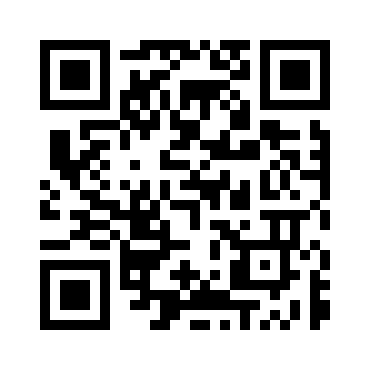

In [42]:
import qrcode
from PIL import Image

data = "https://www.example.com"

qr = qrcode.QRCode(
    version = 1,
    error_correction = qrcode.constants.ERROR_CORRECT_H,
    box_size = 10,
    border = 4,
)

qr.add_data(data)
qr.make(fit=True)
img = qr.make_image()
display(img)
# img.save("image.png")